In [46]:
from uobrainflex.utils import djconnect
from uobrainflex.pipeline import subject as subjectSchema
from uobrainflex.pipeline import acquisition as acquisitionSchema
from uobrainflex.pipeline import experimenter as experimenterSchema
from uobrainflex.nwb import loadbehavior as load
from uobrainflex.behavioranalysis import flex_hmm
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import kstest
from sklearn.preprocessing import scale
import statsmodels.stats.weightstats as ws
from statistics import mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# specify existing directory to save summary figures to. 
save_folder = '' # if save_folder == '', plots will be generated but not saved

# import behavior session database from datajoint. 
djSubject = subjectSchema.Subject()
djExperimenter = experimenterSchema.Experimenter()
djBehaviorSession = acquisitionSchema.BehaviorSession()
all_sessions = djBehaviorSession.fetch(format='frame')

# filter sessions as desired, this could also include a minimum hits/choices per session
subject = 'BW041'
training_stage = 'S6'
hmm_sessions = all_sessions.query("subject_id==@subject and behavior_training_stage==@training_stage")

# get nwbfilepaths
nwbfilepaths = []
for fileID in hmm_sessions.index:                                               #instead of using DJ to find fileIDs, fileID could be a range of dates
    this_session = load.get_file_path(subject,str(fileID[6:]))
    if this_session:
        nwbfilepaths.append(this_session)
        
nwbfilepaths = nwbfilepaths[-20:] # truncate sessions used for this example
## fitting GLM-HMM from list of filepaths`
# load and format data. Getting behavior measures will significantly slow this down.
inpts, true_choices, hmm_trials = flex_hmm.compile_choice_hmm_data(nwbfilepaths, get_behavior_measures = True)

## generate glm-hmm model
# model fitting to determine number of states takes a while -- not shown here
# num_states = flex_hmm.choice_hmm_sate_fit(subject, inpts, true_choices, max_states = 6,save_folder='')
num_states = 4
hmm = flex_hmm.choice_hmm_fit(subject, num_states, inpts, true_choices)
# include model outpit in trial data structures
posterior_probs, hmm_trials = flex_hmm.get_posterior_probs(hmm, true_choices, inpts, hmm_trials, occ_thresh = 0.8)


/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/datajoint/connection.py:304: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211027T092533.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211028T084958.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211029T090341.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211030T115359.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211031T124852.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211031T134034.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211101T091904.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211102T092635.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211104T084209.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211105T084752.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211106T143439.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211107T105541.nwb
Loading /Volumes/brainflex/behavior/BW041/BW041_behavior_20211108T091227.nwb

  0%|          | 0/200 [00:00<?, ?it/s]

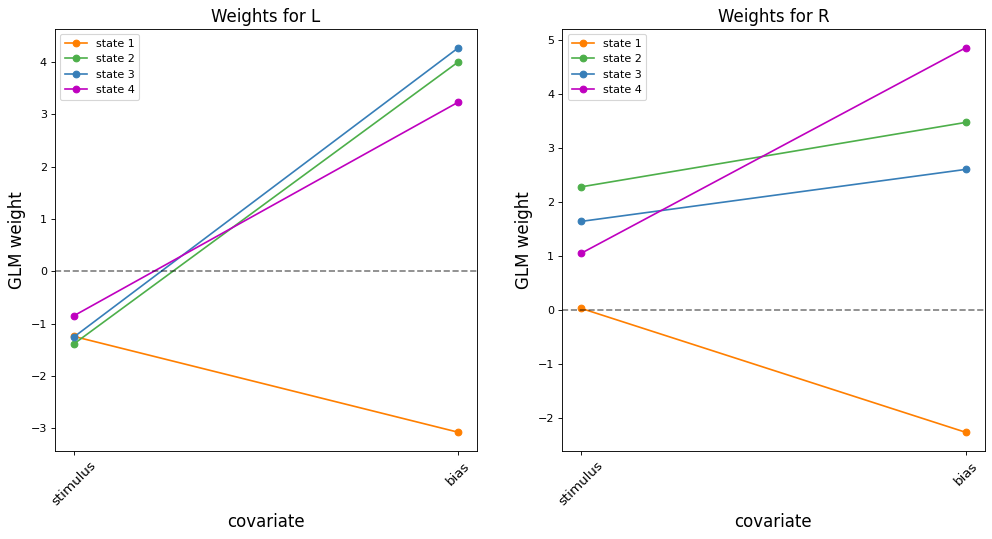

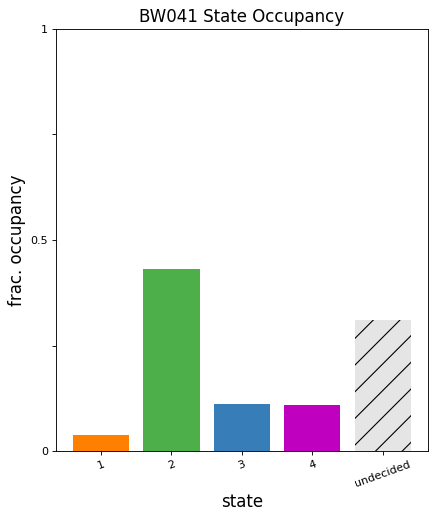

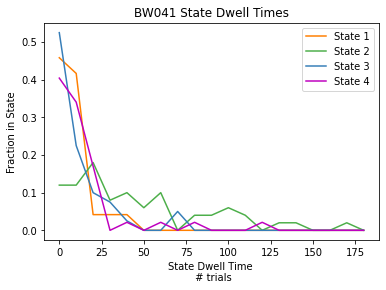

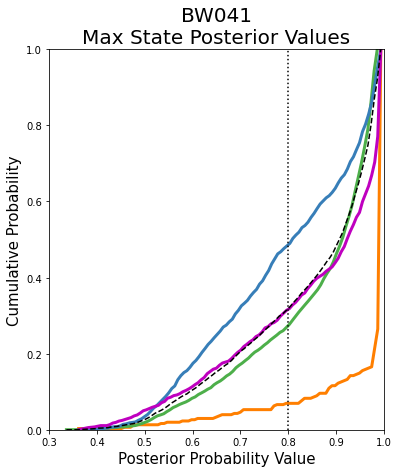

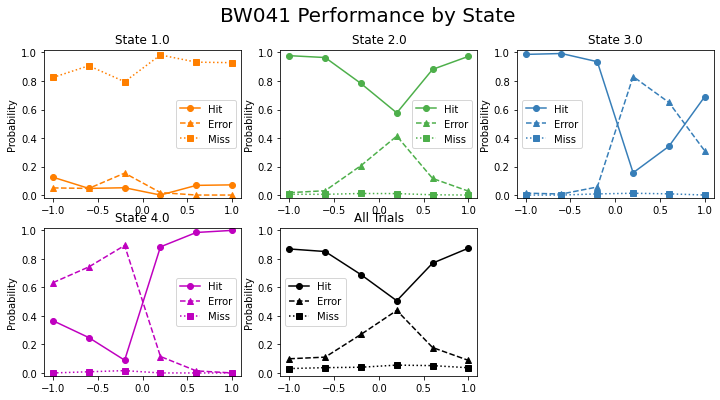

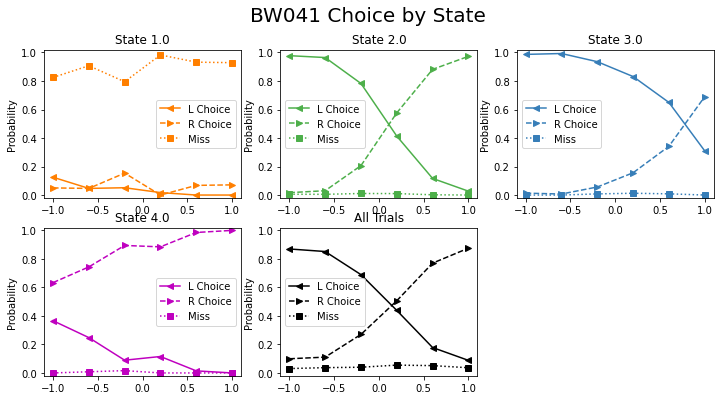

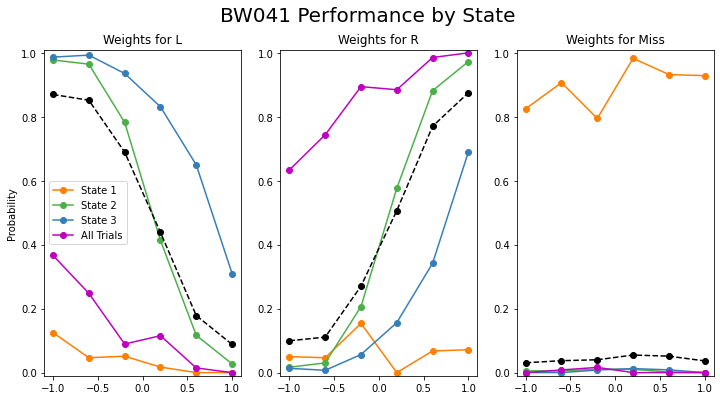

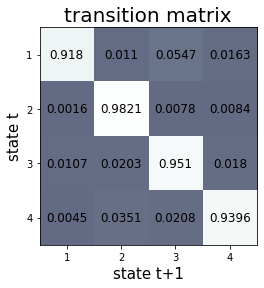

In [17]:
## plot results
flex_hmm.plot_GLM_weights(subject, hmm, save_folder)
flex_hmm.plot_state_occupancy(subject, hmm_trials, save_folder)
state_transitions = flex_hmm.plot_dwell_times(subject, hmm_trials, save_folder)
flex_hmm.plot_state_posteriors_CDF(subject, posterior_probs, save_folder)
flex_hmm.plot_state_psychometrics(subject, hmm, inpts, true_choices, save_folder)
flex_hmm.plot_transition_matrix(subject, hmm, save_folder)

In [164]:
for s, nwbfile in enumerate(nwbfilepaths):
    nwbFileObj = load.load_nwb_file(nwbfile)
    behavior_measures = load.read_behavior_measures(nwbFileObj)
    idx = behavior_measures.index
    measures = behavior_measures.columns
    # filter and normalize pupil diameter data across session
    if any(measures == 'pupil_diameter'):
        raw_pup = behavior_measures['pupil_diameter'].values
    elif any(measures == 'pupil_size'):
        raw_pup = behavior_measures['pupil_size'].values   
    filt_pup = load.savitzky_golay(raw_pup, 1001, 2, deriv=0, rate=1)
    norm_pup = filt_pup/np.nanmax(filt_pup)    
    #filter wheel speed
    raw_run = behavior_measures['running_speed'].values
    filt_run = load.savitzky_golay(raw_run, 201, 2, deriv=0, rate=1)   
    
    #make session ID tag
    sessionID = nwbfile.split('/')[-1]
    #create dataframe column with session ID
    columns = ['pupil_size', 'running_speed', 'whisker_energy', 'hmm_state', 'session_id']
    all_data = pd.DataFrame(columns=columns)
    #loop through each trial
    for trial in hmm_trials[s].index:
        trial_df = pd.DataFrame(columns=columns)
        #get start sample and end sample
        trial_start = hmm_trials[s].loc[trial,'stimulus_time']
        trial_stop = hmm_trials[s].loc[trial,'stop_time']
        start_sample = round(trial_start/.001) ####danger! this assumes ms sampling of behavior measures
        end_sample = round(trial_stop/.001)
        #get hmm state of trial
        trial_state = hmm_trials[s].loc[trial, 'hmm_state']
        #get all trial data
        pupil_data = norm_pup[idx[start_sample:end_sample]]#get pupil data using the time stamped indices
        run_data = filt_run[idx[start_sample:end_sample]]#get running data
        whisker_data = behavior_measures.loc[start_sample]['whisker_energy']#get whisker energy data
        trial_df['pupil_size'] = pupil_data
        trial_df['running_speed'] = run_data
        trial_df['whisker_energy'] = whisker_data
        trial_df['hmm_state'] = np.ones(len(pupil_data))*trial_state
        trial_df['session_id'] = [sessionID] * len(pupil_data)
        all_data = all_data.append(trial_df, ignore_index=True)

all_data['hmm_state'] = all_data['hmm_state'].fillna(num_states)
all_data['hmm_state'] = all_data['hmm_state'] + 1
all_data['hmm_state'] = all_data['hmm_state'].astype(int).astype(str)
all_data['hmm_state'] = all_data['hmm_state'].replace('5', 'undecided')
all_data['hmm_state'] = pd.Categorical(all_data['hmm_state'], ["1", "2", "3", "4", "undecided"])

<AxesSubplot:>

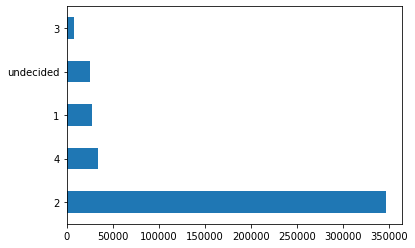

In [172]:
all_data.hmm_state.value_counts().plot(kind = 'barh')

,pupil_size,running_speed,whisker_energy
KS-statistic,0.062743,0.313963,0.0609722
P-value,0,0,0


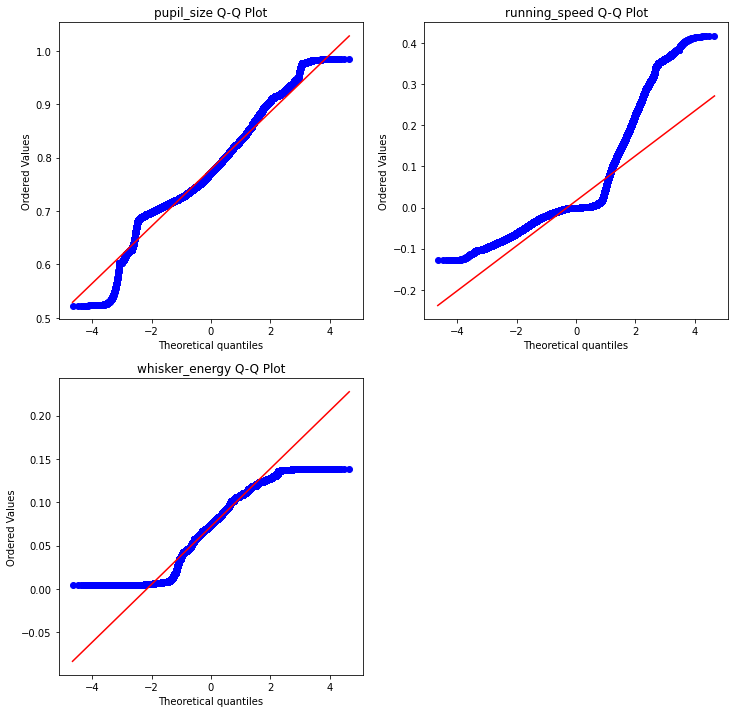

In [173]:
#Compare and test the normality of the distribution of pupil. 
#Use both a graphical method and a formal test.
index = ['KS-statistic', 'P-value']
c = ['pupil_size', 'running_speed', 'whisker_energy']
KS_results = pd.DataFrame(index=index, columns=c)
ks_statistic, pvalue = kstest(scale(all_data['pupil_size'].tolist()), 'norm')
KS_results.at['KS-statistic','pupil_size'] = ks_statistic
KS_results.at['P-value','pupil_size'] = pvalue
ks_statistic, pvalue = kstest(scale(all_data['running_speed'].tolist()), 'norm')
KS_results.at['KS-statistic','running_speed'] = ks_statistic
KS_results.at['P-value','running_speed'] = pvalue
ks_statistic, pvalue = kstest(scale(all_data['whisker_energy'].tolist()), 'norm')
KS_results.at['KS-statistic','whisker_energy'] = ks_statistic
KS_results.at['P-value','whisker_energy'] = pvalue

plt.figure(figsize=(12, 12)).gca() # define axis
ax1 = plt.subplot(221) ## setup the left subplot, price qq plot
res = ss.probplot(all_data['pupil_size'].values, plot = ax1) ## Plot the left subplot
ax1.set_title("pupil_size Q-Q Plot")
ax2 = plt.subplot(222) ## Set up the right subplot, log price qq plot
res = ss.probplot(all_data['running_speed'].values, plot = ax2) ## Plot the right subplot
ax2.set_title("running_speed Q-Q Plot")
ax3 = plt.subplot(223) ## Set up the right subplot, log price qq plot
res = ss.probplot(all_data['whisker_energy'].values, plot = ax3) ## Plot the right subplot
ax3.set_title("whisker_energy Q-Q Plot")
KS_results

The Kolmogorov-Smirnov distribution test was done to indicate the normality of the pupil_size and other beahvioral variable distributions. The K-S statistic indicates that the pupil_size distribution does not deviate significantly from a normal distribution. The K-S statistic is quite small and the p-value is less than 0.05. The probability is low that the difference arises by chance alone.

The quantile-quantile (Q-Q) plot illustrates graphically the differences in normality between the pupil_size and the other behavioral variable distributions. A point (x, y) on the plot corresponds to one of the quantiles of the second distribution (y-coordinate) plotted against the same quantile of the first distribution (x-coordinate). The Q-Q plot for the pupil size distibution does not significantly deviate from the standard normal (red) line.

Ordered values is simply sorted input variable.

,1 vs. 2,1 vs. 3,1 vs. 4,2 vs. 3,2 vs. 4,3 vs. 4,1 vs. Undecided,2 vs. Undecided,3 vs. Undecided,4 vs. Undecided
DegFreedom,5547.986797,6325.411268,5256.527280,8209.092999,8.611470e+03,7576.431643,5.104275e+03,8.304581e+03,7141.019822,8.717952e+03
Difference,-0.050017,-0.148365,-0.069775,-0.098348,-1.975796e-02,0.078590,-3.683617e-02,1.318082e-02,0.111529,3.293878e-02
Statistic,-61.191596,-229.521432,-74.568510,-101.999720,-1.677420e+01,73.699165,-3.592297e+01,1.054189e+01,97.329853,2.475293e+01
PValue,0.000000,0.000000,0.000000,0.000000,3.459994e-62,0.000000,7.650780e-264,7.889450e-26,0.000000,7.942392e-131
Low95CI,-0.051619,-0.149632,-0.071609,-0.100238,-2.206688e-02,0.076500,-3.884644e-02,1.072987e-02,0.109282,3.033029e-02
High95CI,-0.048415,-0.147098,-0.067941,-0.096458,-1.744904e-02,0.080680,-3.482591e-02,1.563178e-02,0.113775,3.554727e-02


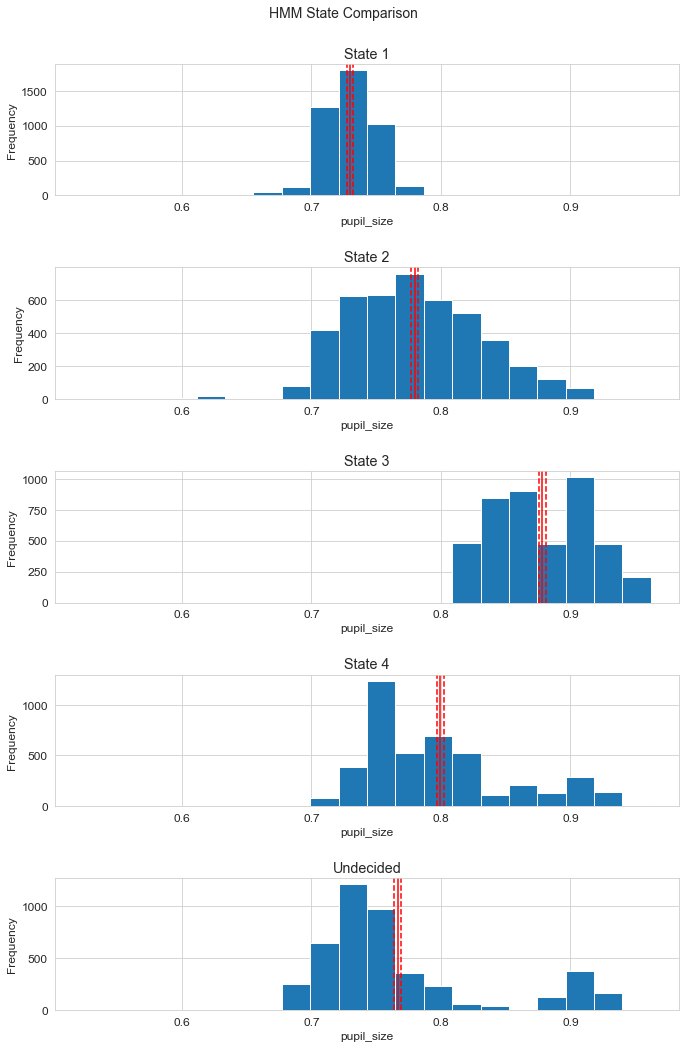

In [308]:
#Test significance of pupil stratified by hmm state
#Use both graphical methods and the formal test.
p = 0.01
alpha = 0.05
index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
c = ['1 vs. 2', '1 vs. 3', '1 vs. 4', '2 vs. 3', '2 vs. 4', '3 vs. 4']
tt_results = pd.DataFrame(index=index, columns=c)

def stratify(dat, p, group):
    groups = dat.groupby(group) # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * dat.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return.
        return groups.apply(lambda x: x.sample(n=num))
    else: # Oops. p is to large
        pmax = nums / dat.shape[0]
        print('Error for ' + group + ":")
        print('The maximum value of p = ' + str(pmax))

def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b)
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

def hist_mean_ci(vec, t_test, bins, ax):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    ax.hist(vec, bins = bins)
    ax.axvline(mean(vec), color = 'red')
    ax.axvline(upper, color = 'red', linestyle='--')
    ax.axvline(lower, color = 'red', linestyle='--')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('pupil_size')
    
def plot_t(a, b, t_test, title = '', cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.set_title(cols[0])
    hist_mean_ci(a, t_test, bins, ax1)
    ax2.set_title(cols[1])
    hist_mean_ci(b, t_test, bins, ax2)
    f.suptitle(title, fontsize=14)

def plot_t_all(data, t_test, cols, title = '', nbins = 20):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(data),1, figsize=(10, 15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i, s in enumerate(data):
        if i == 0:
            minx = min(s)
            maxx = max(s)
        else:
            minx = min([min(s), minx])
            maxx = max([max(s), maxx])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    for i, s in enumerate(data):
        axs[i].set_title(cols[i])
        hist_mean_ci(s, t_test, bins, axs[i])
    fig.suptitle(title, fontsize=14)
    fig.tight_layout(pad=2.0)

#function to split the stratified sample dataframe into separate dataframes per group for plotting and analysis
def strat_split(dat, s, cat, group):
    groups = dat[cat].unique()
    for b in groups:
        split = s[s[cat] == group]
    return split

#stratify and sample each group of interest
strat_hmm = stratify(all_data, p, 'hmm_state')#sample hmm state groups

#separate groups for significance testing
strat_1 = strat_split(all_data, strat_hmm, 'hmm_state', '1')
strat_2 = strat_split(all_data, strat_hmm, 'hmm_state', '2')
strat_3 = strat_split(all_data, strat_hmm, 'hmm_state', '3')
strat_4 = strat_split(all_data, strat_hmm, 'hmm_state', '4')
strat_u = strat_split(all_data, strat_hmm, 'hmm_state', 'undecided')

#test for significance
tt_test = t_test(strat_1['pupil_size'], strat_2['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 2'] = tt_test
#plot_t(strat_1['pupil_size'], strat_2['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 2'])

tt_test = t_test(strat_1['pupil_size'], strat_3['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 3'] = tt_test
#plot_t(strat_1['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 3'])

tt_test = t_test(strat_1['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 4'] = tt_test
#plot_t(strat_1['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 4'])

tt_test = t_test(strat_2['pupil_size'], strat_3['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. 3'] = tt_test
#plot_t(strat_2['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 3'])

tt_test = t_test(strat_2['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. 4'] = tt_test
#plot_t(strat_2['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 4'])

tt_test = t_test(strat_3['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['3 vs. 4'] = tt_test
#plot_t(strat_3['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 3', 'State 4'])

tt_test = t_test(strat_1['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_2['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 2'])

tt_test = t_test(strat_2['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 3'])

tt_test = t_test(strat_3['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['3 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 4'])

tt_test = t_test(strat_4['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['4 vs. Undecided'] = tt_test
#plot_t(strat_2['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 3'])

all_strats = [strat_1['pupil_size'], strat_2['pupil_size'], 
              strat_3['pupil_size'], strat_4['pupil_size'],
              strat_u['pupil_size']] 
plot_t_all(all_strats, tt_test, ['State 1', 'State 2', 'State 3', 'State 4', 'Undecided'], 'HMM State Comparison')

tt_results

There is a statistically significant difference in pupil_size between the HMM states because the p-values are small and the 95% confidence intervals don't encompass 0. In addition there are relatively large differences between the means of each distribution.

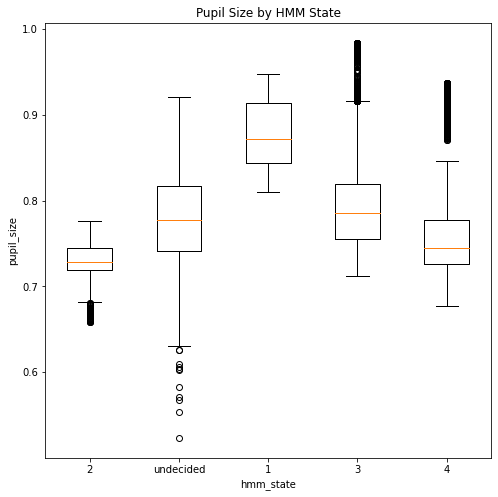

In [198]:
#box plot of the log price by body style group
f, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(all_strats)
ax.set_ylabel('pupil_size')
ax.set_xlabel('hmm_state')
ax.set_title('Pupil Size by HMM State')
ax.set_xticklabels(all_data['hmm_state'].unique());#set x tick labels of the box plot to the body style categories

In [199]:
#Apply ANOVA and Tukey's HSD test
pls1 = strat_1['pupil_size'].tolist()#list of pupil size for state 1 stratified sample
pls2 = strat_2['pupil_size'].tolist()#list of pupil size for state 2 stratified sample
pls3 = strat_3['pupil_size'].tolist()#list of pupil size for state 3 stratified sample
pls4 = strat_4['pupil_size'].tolist()#list of pupil size for state 4 stratified sample
plsu = strat_u['pupil_size'].tolist()#list of pupil size for undecided state stratified sample

#Apply ANOVA
f_statistic, p_value = ss.f_oneway(pls1, pls2, pls3, pls4, plsu)#models the ANOVA of the values by groups
index = ['F-statistic', 'P-value']
col = ['ANOVA-Result']
ANOVA_results = pd.DataFrame(index=index, columns=col)
ANOVA_results.at['F-statistic', 'ANOVA-Result'] = f_statistic #stores F statistic of the ANOVA model
ANOVA_results.at['P-value', 'ANOVA-Result'] = p_value #stores p value of the ANOVA model

#Apply Tukey ANOVA
df_t = pd.DataFrame({'vals': pls1 + pls2 + pls3 + pls4 + plsu,
                   'group_num': ['State 1'] * len(pls1) + ['State 2'] * len(pls2) + ['State 3'] * len(pls3) + ['State 4'] * len(pls4) + ['Undecided'] * len(pls1)})#concatenate stratified group samples

Tukey_HSD = pairwise_tukeyhsd(df_t.vals, df_t.group_num)#multiple comparison of means, Tukey HSD Test
print(Tukey_HSD)#print result of Tukey's HSD test
ANOVA_results#outputs results of the ANOVA model

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
State 1   State 2   0.0505 0.001  0.0476  0.0533   True
State 1   State 3   0.1479 0.001   0.145  0.1507   True
State 1   State 4   0.0701 0.001  0.0672  0.0729   True
State 1 Undecided   0.0364 0.001  0.0335  0.0393   True
State 2   State 3   0.0974 0.001  0.0945  0.1003   True
State 2   State 4   0.0196 0.001  0.0167  0.0225   True
State 2 Undecided  -0.0141 0.001 -0.0169 -0.0112   True
State 3   State 4  -0.0778 0.001 -0.0807 -0.0749   True
State 3 Undecided  -0.1115 0.001 -0.1143 -0.1086   True
State 4 Undecided  -0.0337 0.001 -0.0365 -0.0308   True
-------------------------------------------------------


,ANOVA-Result
F-statistic,5431.01
P-value,0


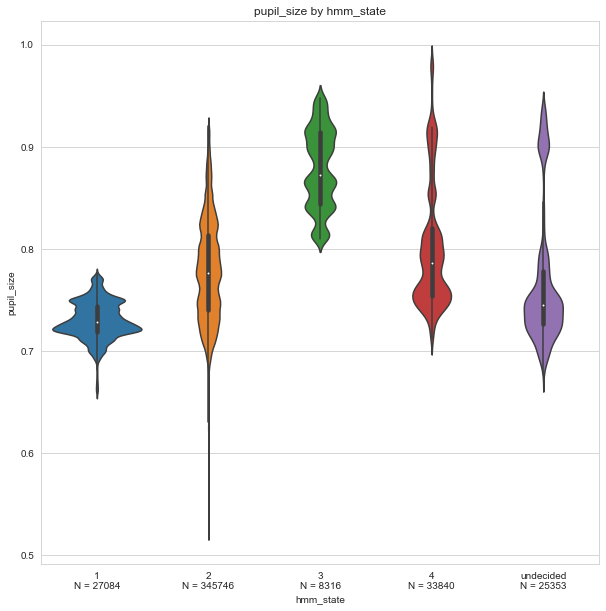

In [202]:
#Graphically explore the differences between the pupil conditioned by the categories of hmm_state. 
df_p = all_data.copy()#copy original dataframe for plotting
sns.set_style("whitegrid")#set seaborn style with grid line
df_p['count'] = pd.Series(np.random.randn(len(df_p)), index=all_data.index)#set up count column to count size of groups

#function that plots violin plot of different categories of individual data set variables
def graph_explorer(dat, x, y, l = 10, w = 10):
    f, ax = plt.subplots(figsize=(w,l))
    cats = dat.groupby([x], as_index=False)['count'].agg('count')#count entries per variable category
    sns.violinplot(x = x, y = y, data = dat, ax = ax)#violin plot of given variable
    ind = list(cats.index.values)
    labels = []
    for i in ind:
        c = cats.at[i, x]
        if type(c) is not str:
            c = c.astype(str)
        n = cats.at[i, 'count']
        if type(n) is not str:
            n = n.astype(str)
        l = c + '\nN = ' + n
        labels.append(l)
    ax.set_xticklabels(labels)
    ax.set_title(y + ' by ' + x)

#remove missing entries from individual categories and create separate dataframes to plot available data for each
df_violin = df_p.dropna(subset=['hmm_state'])

graph_explorer(df_violin, 'hmm_state', 'pupil_size')#plot violin plot of log-price for symboling

ANOVA assumes:

(1) the samples are independent.

(2) Each sample is from a normally distributed population.

(3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [205]:
#Test for pupil differences with Kruskal-Wallis H-test of pupil stratified by hmm state
ss.kruskal(strat_1['pupil_size'], strat_2['pupil_size'], 
              strat_3['pupil_size'], strat_4['pupil_size'],
              strat_u['pupil_size'])

KruskalResult(statistic=11156.641418591316, pvalue=0.0)

In [207]:
#Test significance with Mann-Whitney U test of pupil stratified by hmm state
p = 0.01
alpha = 0.05
index = ['Statistic', 'PValue']
c = ['1 vs. 2', '1 vs. 3', '1 vs. 4', '2 vs. 3', '2 vs. 4', '3 vs. 4']
tt_results = pd.DataFrame(index=index, columns=c)

def mw_test(a, b, alpha, alternative='two-sided'):
    res = ss.mannwhitneyu(a, b, alternative=alternative)
    index = ['Statistic', 'PValue']
    return pd.Series([res[0], res[1]], index = index)   


#test for significance
tt_test = mw_test(strat_1['pupil_size'], strat_2['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 2'] = tt_test
#plot_t(strat_1['pupil_size'], strat_2['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 2'])

tt_test = mw_test(strat_1['pupil_size'], strat_3['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 3'] = tt_test
#plot_t(strat_1['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 3'])

tt_test = mw_test(strat_1['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. 4'] = tt_test
#plot_t(strat_1['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 4'])

tt_test = mw_test(strat_2['pupil_size'], strat_3['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. 3'] = tt_test
#plot_t(strat_2['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 3'])

tt_test = mw_test(strat_2['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. 4'] = tt_test
#plot_t(strat_2['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 4'])

tt_test = mw_test(strat_3['pupil_size'], strat_4['pupil_size'], alpha, alternative='two-sided')
tt_results['3 vs. 4'] = tt_test
#plot_t(strat_3['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 3', 'State 4'])

tt_test = mw_test(strat_1['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['1 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_2['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 2'])

tt_test = mw_test(strat_2['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['2 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 3'])

tt_test = mw_test(strat_3['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['3 vs. Undecided'] = tt_test
#plot_t(strat_1['pupil_size'], strat_4['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 1', 'State 4'])

tt_test = mw_test(strat_4['pupil_size'], strat_u['pupil_size'], alpha, alternative='two-sided')
tt_results['4 vs. Undecided'] = tt_test
#plot_t(strat_2['pupil_size'], strat_3['pupil_size'], tt_test, 'HMM State Comparison', cols=['State 2', 'State 3'])

# all_strats = [strat_1['pupil_size'], strat_2['pupil_size'], 
#               strat_3['pupil_size'], strat_4['pupil_size'],
#               strat_u['pupil_size']] 
#plot_t_all(all_strats, tt_test, ['State 1', 'State 2', 'State 3', 'State 4', 'Undecided'], 'HMM State Comparison')

tt_results


,1 vs. 2,1 vs. 3,1 vs. 4,2 vs. 3,2 vs. 4,3 vs. 4,1 vs. Undecided,2 vs. Undecided,3 vs. Undecided,4 vs. Undecided
Statistic,3542271.0,0.0,1434901.0,1332619.0,8.214868e+06,16575448.0,6.412050e+06,1.222104e+07,17226851.0,1.411924e+07
PValue,0.0,0.0,0.0,0.0,2.826816e-35,0.0,1.419483e-166,1.125940e-99,0.0,2.258058e-301


In [332]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

all_strats = [strat_1, strat_2, strat_3, strat_4, strat_u]

print("ALL STATES")
cw = all_data[['pupil_size', 'running_speed', 'whisker_energy', 'hmm_state']]
cw_lm=ols('pupil_size ~ running_speed + whisker_energy + C(hmm_state)', data=cw).fit() #Specify C for Categorical
table = sm.stats.anova_lm(cw_lm, typ=2)
print(table)

for i, strat in enumerate(all_strats):
    if i == len(all_strats)-1:
        print("\n UNDECIDED ")
    else:
        print("\n STATE " + str(i+1))
    cw = strat[['pupil_size', 'running_speed', 'whisker_energy']]
    cw_lm=ols('pupil_size ~ running_speed + whisker_energy', data=cw).fit() #Specify C for Categorical
    table = sm.stats.anova_lm(cw_lm, typ=2)
    print(table)
    

ALL STATES
                     sum_sq        df             F  PR(>F)
C(hmm_state)     165.208648       4.0  16517.981776     0.0
running_speed     25.657614       1.0  10261.254706     0.0
whisker_energy     4.460346       1.0   1783.826971     0.0
Residual        1101.022140  440332.0           NaN     NaN

 STATE 1
                  sum_sq      df           F        PR(>F)
running_speed   0.047698     1.0  149.654777  7.279313e-34
whisker_energy  0.059129     1.0  185.520771  2.066347e-41
Residual        1.402371  4400.0         NaN           NaN

 STATE 2
                   sum_sq      df          F        PR(>F)
running_speed    0.142708     1.0  55.614697  1.056021e-13
whisker_energy   0.002029     1.0   0.790682  3.739427e-01
Residual        11.290435  4400.0        NaN           NaN

 STATE 3
                  sum_sq      df           F        PR(>F)
running_speed   0.203525     1.0  141.569859  3.740962e-32
whisker_energy  0.008716     1.0    6.062568  1.384574e-02
Residual  

predict state based on behavioral measures



2-way Type 2 sum of squares ANOVA. Meaning: does not sequentially assign variation effects to variables, no interaction term included. 

The sum of the squares of the deviations of the predicted values from the mean value of a response variable. In other words, the ANOVA linear model sum of squares is the variation attributed to the relationship between the x's and y's,. The sum of squares of the residual error is the variation attributed to the error. df denotes degree of freedom, i.e. the number of values in the final calculation of a statistic that are free to vary. The residual degrees of freedom are the remaining "dimensions" that you could use to generate a new data set that "looks" like your current data set. 

The F-test is the ratio of the mean square of the variable divided by the mean square of each parameter. Mean square  is the sum of squares divided by the degrees of freedom. So a large F stat means that the variation between samples is larger than the variation within the individual samples.



Standard ANOVA models were applied. The model was subsequently screened by p-value less than 0.05.  A Tukey HSD test was applied to the behavioral variables to test the differences of their respective HMM state distributions.

Non-parametric methods were used as well: Kruskall-Wallis (non-parametric version of ANOVA) and a post-hoc Mann-Whitney (non-parametric version of Tukey's HSD test. The conclusions were the same.

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fmin
from sklearn import preprocessing
from matplotlib import rcParams
from sklearn import linear_model
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
from copy import deepcopy
import math
from matplotlib import gridspec
import pandas as pd
import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split

In [320]:
def pupLinearRegression(strat):
    state_data = strat[['pupil_size', 'whisker_energy', 'running_speed']]
    y = state_data['pupil_size'].to_numpy()
    X = state_data[['whisker_energy', 'running_speed']].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    A = X_train
    b = np.expand_dims(y_train, axis=1)

    n = X_train.shape[0] #number of time points
    m = X_train.shape[1] #number of features
    p = b.shape[1] #number of output features

    #Begin by investigating different mappings (regularizations) from image space to label space
    lam = 0.1#lambda value used in Elastic Net to indicate how much l1 penalty (Lasso) to included relative to l2 (ridge)
    #alpha = 2.0
    cv_folds = 5#number of cross validation folds
    kf = KFold(n_splits = cv_folds, random_state = 42, shuffle = True)#initialize KFold for iterative cross validation 

    #initialize numpy arrays to hold error values for each cross validation fold
    E1 = np.zeros(cv_folds)#pinv errors
    E2 = np.zeros(cv_folds)#least squares errors
    E3 = np.zeros(cv_folds)#E net alpha 1.0 errors
    E4 = np.zeros(cv_folds)#E net alpha 0.8 errors
    E5 = np.zeros(cv_folds)#Huber errors
    E6 = np.zeros(cv_folds)#Ridge errors

    #initialize numpy arrays to hold model coefficients
    X1 = np.zeros((m,p,cv_folds))#pinv
    X2 = np.zeros((m,p,cv_folds))#least squares
    X3 = np.zeros((m,p,cv_folds))#E net alpha 1.0
    X4 = np.zeros((m,p,cv_folds))#E net alpha 0.8
    X5 = np.zeros((m,p,cv_folds))#Huber errors
    X6 = np.zeros((m,p,cv_folds))#Ridge errors

    jj = 0#inititalize iterator for storing errors and coefficients for each cross validation fold

    #for each subset of training data A fit a model of each type pinv, lstsq, ElasticNet alpha 1.0,
    #ElasticNet alpha 0.8, Huber, Ridge
    for train_index, test_index in kf.split(A):
        print("Progress {:2.1%}".format(jj / cv_folds), end="\r")#print progress

        #pinv solver
        x1 = np.linalg.pinv(A[train_index,:]) @ b[train_index,:]#map from pixel space in test data to test data label space
        b1 = A[train_index,:] @ x1#apply model to data
        E1[jj] = np.linalg.norm(b[train_index,:] - b1,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

        x2 = np.linalg.lstsq(A[train_index,:],b[train_index,:],rcond=None)[0]#map from pixel space in test data to test data label space
        b2 = A[train_index,:] @ x2#apply model to data
        E2[jj] = np.linalg.norm(b[train_index,:]-b2,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    #     regr3 = linear_model.ElasticNet(alpha=0.1, copy_X=True, l1_ratio=lam, max_iter=10**5,random_state=0)
    #     regr3.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space
    #     x3 = np.transpose(regr3.coef_)#ElasticNet method give coefficients of flipped dimensions
    #     b3 = A[train_index,:] @ x3#apply model to data
    #     E3[jj] = np.linalg.norm(b[train_index,:]-b3,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    #     regr4 = linear_model.ElasticNet(alpha=0.5, copy_X=True, l1_ratio=lam, max_iter=10**5,random_state=0)
    #     regr4.fit(A[train_index,:], b[train_index,:]) #map from pixel space in test data to test data label space
    #     x4 = np.transpose(regr4.coef_)#ElasticNet method give coefficients of flipped dimensions
    #     b4 = A[train_index,:] @ x4#apply model to data
    #     E4[jj] = np.linalg.norm(b[train_index,:]-b4,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    #     regr5 = MultiOutputRegressor(linear_model.HuberRegressor(), n_jobs=-1)#using multioutputregressor as huber regressor method does not support multioutput
    #     huber = regr5.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space

    #     x5 = np.empty([m, p])#initialize empty numpy array to hold the huber coefficients
    #     #iterate over each estimator for each of the multiple outputs
    #     for i in range(0, len(huber.estimators_)):
    #         x5[:, i] = huber.estimators_[i].coef_#grab each estimator's coefficients and fill in column of X

    #     b5 = A[train_index,:] @ x5#apply model to data
    #     E5[jj] = np.linalg.norm(b[train_index,:]-b5,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

        ridge = linear_model.Ridge(alpha=0.0).fit(A[train_index,:],b[train_index,:])#map from pixel space in test data to test data label space
        x6 = np.transpose(ridge.coef_)#Ridge method returns coefficient array with flipped dimensions
        b6 = A[train_index,:] @ x6#apply model to data
        E6[jj] = np.linalg.norm(b[train_index,:] - b6,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

        X1[:,:,jj] = x1#pinv coefficients
        X2[:,:,jj] = x2#least squares coefficients
        # X3[:,:,jj] = np.expand_dims(x3, axis=1)#ElasticNet alpha=1.0 coefficients
        # X4[:,:,jj] = np.expand_dims(x4, axis=1)#ElasticNet alpha=0.8 coefficients
        # X5[:,:,jj] = x5#Huber (Robust) coefficients
        X6[:,:,jj] = x6#Ridge coefficients

        jj = jj + 1#iterate so that the errors and coefficients from the next cross fold can be stored


    Err = np.column_stack((E1,E2,E6))#E3,E4,E5,E6))#concatenate all errors together for plotting

    reg_styles = ['pinv', 'lstsq', 'ridge']#'elastic (alpha=1)', 'elastic (alpha=0.8)', 'huber', 'ridge']#types of Ax=b solvers used
    Xdict = [X1, X2, X6]#X3, X4, X5, X6]#list of model coefficients for plotting
    
    return Xdict, Err

def plotLinRegPerformance(Xdict, Err, title):
    #create heat map of coefficient values for each solver
    c = 2
    r = int(len(reg_styles)/c)
    if len(reg_styles)%2>0:
        r = r + 1
        fig, axs = plt.subplots(r,c, figsize=(6, 8), 
                                facecolor='w', edgecolor='k', sharex=True)
        axs = axs.ravel()
        fig.delaxes(axs[-1])
    else:
        fig, axs = plt.subplots(r,c, figsize=(6, 8), 
                            facecolor='w', edgecolor='k', sharex=True)
        axs = axs.ravel()


    #axs = axs.reshape(-1)
    x_pos = np.arange(m)
    x_tick_labels = ['running_speed', 'whisker_energy']
    #iterate over solver types and make a subplot heat map
    for j in range(0, len(reg_styles)):
        x = np.average(Xdict[j], axis=2)#average across cross validated coefficient values
        error = np.std(Xdict[j], axis=2)
        axs[j].bar(x_pos, x.flatten(), yerr=error.flatten(), align='center', alpha=0.5, ecolor='black', capsize=10)
        axs[j].set_xticks(x_pos)
        axs[j].set_xticklabels(x_tick_labels, rotation = 45)
        axs[j].yaxis.grid(True)
        axs[j].set_ylabel('Coef Mag')
        axs[j].set_title(reg_styles[j])
    fig.tight_layout(pad=2.0)
    fig.suptitle(title, fontsize=14)

    #plot k fold cross validated errors for each solver type
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.figure()
    plt.boxplot(Err)
    plt.xticks([1, 2, 3], ['pinv', 'np.linalg.solve', 'Ridge'], rotation=40)#''Elastic 1.0', 'Elastic 0.8', 'Huber', 'Ridge'], rotation=40)
    plt.title(title)
    plt.show()
    

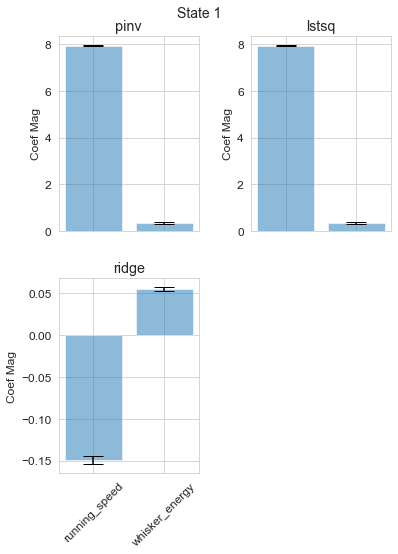

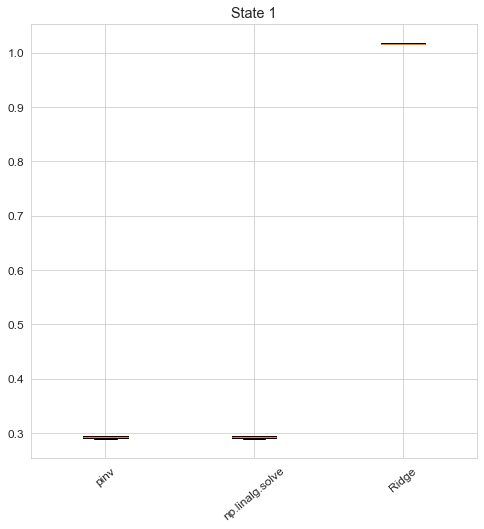

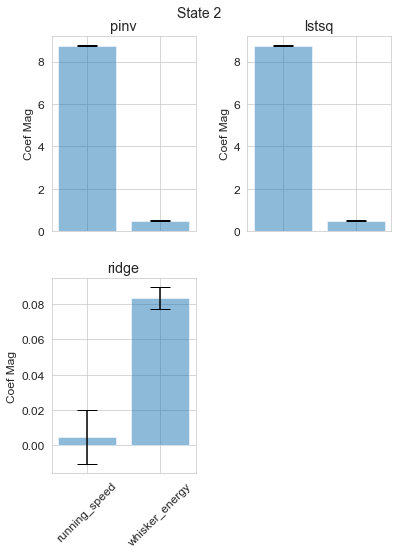

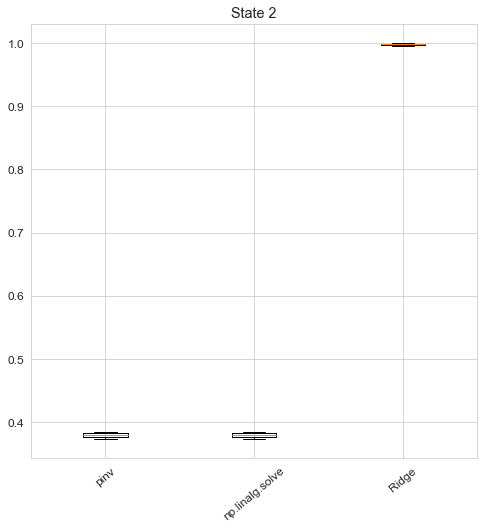

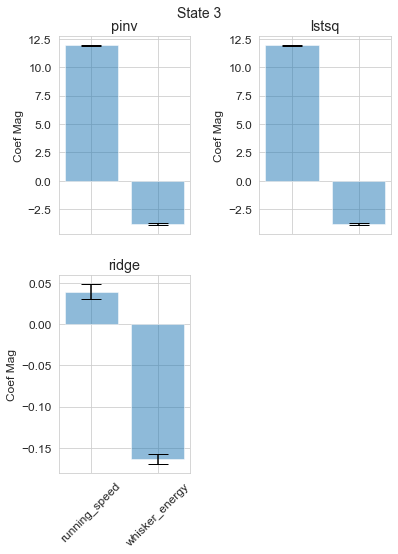

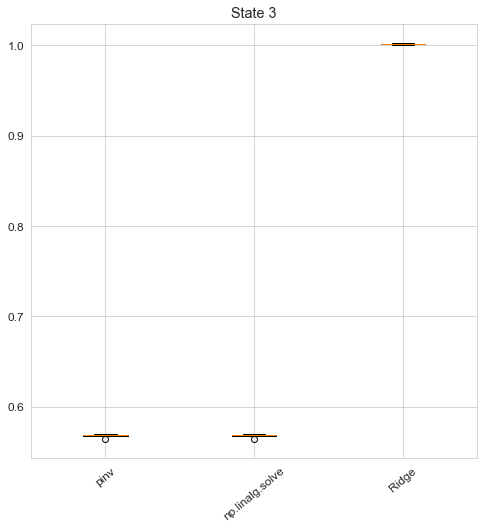

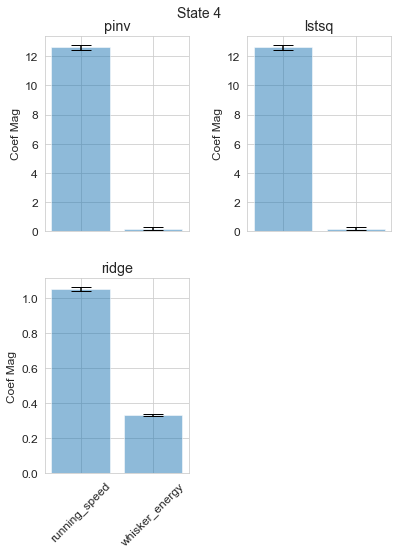

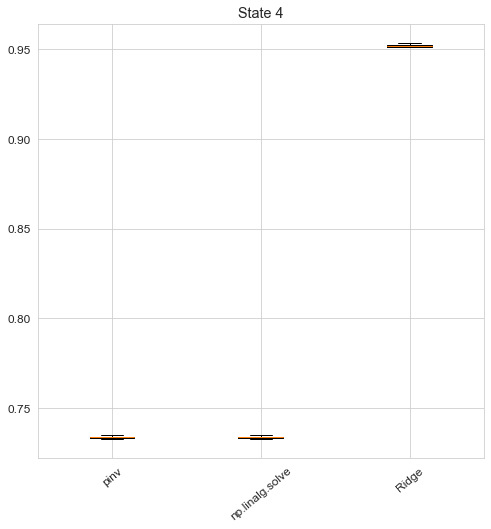

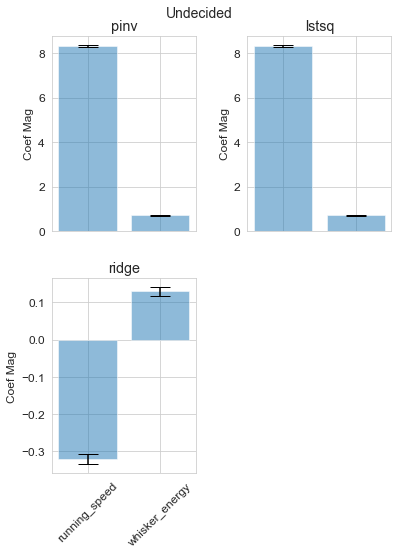

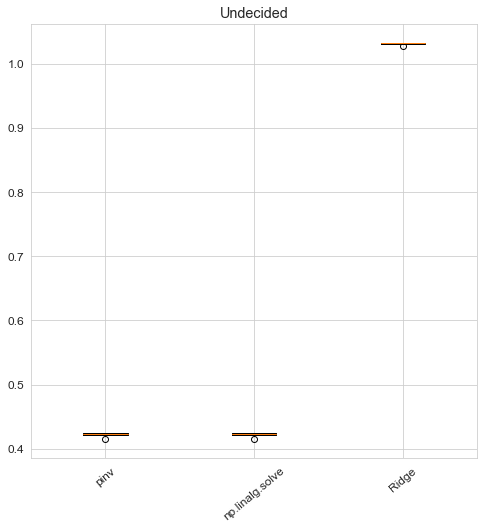

In [321]:
all_strats = [strat_1, strat_2, strat_3, strat_4, strat_u]
titles = ['State 1', 'State 2', 'State 3', 'State 4', 'Undecided']
for i, strat in enumerate(all_strats):
    Xdict, Err = pupLinearRegression(strat)
    title = titles[i]
    plotLinRegPerformance(Xdict, Err, title)